<a href="https://colab.research.google.com/github/jakegehri/twitter-bot/blob/master/emotion_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! huggingface-cli login

In [5]:
! pip install datasets
from datasets import list_datasets
import tensorflow as tf
from transformers import pipeline, PushToHubCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
all_datasets = list_datasets()
print(all_datasets[0:5])

['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus']


In [7]:
from datasets import load_dataset

In [8]:
emotions = load_dataset('emotion')

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [10]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [11]:
import pandas as pd

In [12]:
emotions.set_format(type = 'pandas')

In [13]:
df = emotions['train'][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [14]:
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)
df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


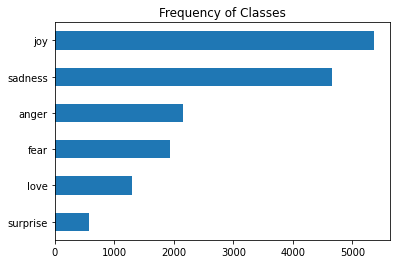

In [15]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


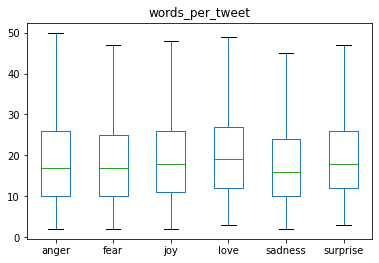

In [16]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot('words_per_tweet', by='label_name', grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [17]:
emotions.reset_format()

In [18]:
! pip install transformers
from transformers import AutoTokenizer

model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 34.2 MB/s 
     |████████████████████████████████| 6.6 MB 56.8 MB/s 


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [19]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [20]:
print(tokenize(emotions['train'][0:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [21]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
from transformers import TFAutoModelForSequenceClassification

num_labels = 6

tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
tf_model

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [23]:
from sklearn.metrics import accuracy_score, f1_score

In [24]:
tokenizer_columns = tokenizer.model_input_names

In [25]:
batch_size = 64

In [26]:
tf_train_dataset = emotions_encoded['train'].to_tf_dataset(columns = tokenizer_columns, 
                                                           label_cols = ['label'], 
                                                           shuffle=True, batch_size=batch_size)

tf_validation_dataset = emotions_encoded['validation'].to_tf_dataset(columns = tokenizer_columns, 
                                                           label_cols = ['label'], 
                                                           shuffle=True, batch_size=batch_size)

In [54]:
callbacks = [PushToHubCallback("model_output/",
                               tokenizer=tokenizer,
                               hub_model_id="twitter-emotion-classifier-BERT")]

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics = tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data = tf_validation_dataset, epochs = 2, callbacks=callbacks)

Cloning https://huggingface.co/jakegehri/twitter-emotion-classifier-BERT into local empty directory.


Download file tf_model.h5:   0%|          | 3.48k/256M [00:00<?, ?B/s]

Download file model.png:  14%|#3        | 409/2.91k [00:00<?, ?B/s]

Download file variables/variables.index: 100%|##########| 6.16k/6.16k [00:00<?, ?B/s]

Download file variables/variables.data-00000-of-00001:   0%|          | 3.52k/255M [00:00<?, ?B/s]

Clean file model.png:  34%|###4      | 1.00k/2.91k [00:00<?, ?B/s]

Clean file variables/variables.index:  16%|#6        | 1.00k/6.16k [00:00<?, ?B/s]

Download file saved_model.pb:   0%|          | 405/3.35M [00:00<?, ?B/s]

Download file keras_metadata.pb:   1%|          | 407/71.2k [00:00<?, ?B/s]

Clean file keras_metadata.pb:   1%|1         | 1.00k/71.2k [00:00<?, ?B/s]

Clean file saved_model.pb:   0%|          | 1.00k/3.35M [00:00<?, ?B/s]

Clean file tf_model.h5:   0%|          | 1.00k/256M [00:00<?, ?B/s]

Clean file variables/variables.data-00000-of-00001:   0%|          | 1.00k/255M [00:00<?, ?B/s]

Epoch 1/2
  6/250 [..............................] - ETA: 2:05 - loss: 0.1446 - sparse_categorical_accuracy: 0.9245

250/250 [==============================] - 163s 624ms/step - loss: 0.1101 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1436 - val_sparse_categorical_accuracy: 0.9345
Epoch 2/2
250/250 [==============================] - 136s 545ms/step - loss: 0.0868 - sparse_categorical_accuracy: 0.9599 - val_loss: 0.1442 - val_sparse_categorical_accuracy: 0.9325


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file tf_model.h5:   0%|          | 3.34k/256M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/jakegehri/twitter-emotion-classifier-BERT
   a929610..8b9eebc  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/jakegehri/twitter-emotion-classifier-BERT
   a929610..8b9eebc  main -> main



In [55]:
tf_model.push_to_hub("twitter-emotion-classifier-BERT")

In [68]:
classifier = pipeline("text-classification", model = "jakegehri/twitter-emotion-classifier-BERT")

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at jakegehri/twitter-emotion-classifier-BERT were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at jakegehri/twitter-emotion-classifier-BERT and are newly initialized: ['dropout_98']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [96]:
test_tweet = "joy"

In [97]:
preds = classifier(test_tweet, top_k=6)
preds

[{'label': 'LABEL_1', 'score': 0.9766085147857666},
 {'label': 'LABEL_0', 'score': 0.01097695343196392},
 {'label': 'LABEL_2', 'score': 0.004367642104625702},
 {'label': 'LABEL_3', 'score': 0.0036679967306554317},
 {'label': 'LABEL_5', 'score': 0.0024430735502392054},
 {'label': 'LABEL_4', 'score': 0.0019358351128175855}]

In [98]:
labels = emotions['train'].features['label'].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [99]:
preds_df = pd.DataFrame(preds)
preds_df

,label,score
0,LABEL_1,0.976609
1,LABEL_0,0.010977
2,LABEL_2,0.004368
3,LABEL_3,0.003668
4,LABEL_5,0.002443
5,LABEL_4,0.001936


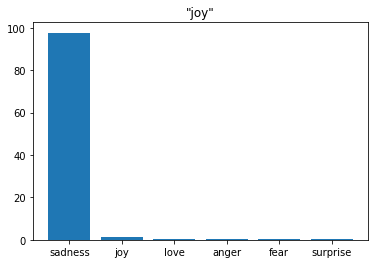

In [100]:
plt.bar(labels, 100 * preds_df['score'], color = 'C0')
plt.title(f'"{test_tweet}"')
plt.show()